# **GMRRNet funcions:** 

Este cuaderno documenta todas las funciones y clases utilizadas para el correcto y buen funcionamiento del modelo.

# **Instalamos lo necesario e importamos librerías**

In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-3tsee6eh
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-3tsee6eh
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit c35637e1a19d7cd21656496339c1dedae6714916
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=94504 sha256=c97b03346d976a26fc2c7ef2eb8975c507bfdc361b9bfd0eb954fb2359bc873e
  Stored in directory: /tmp/pip-ephem-wheel-cache-k5ly5454/wheels/8e/66/a7/91b78b1787a3e4d17cb82ea2da67845aa9389012c0ed8280b0
Successfully built gcpds-databases
  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-zsx2f4i0
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-zsx2f4i0
  Resolved https://github.com/UN-GCPDS/pyth

In [2]:
from gcpds.databases import GIGA_MI_ME
from typing import Optional, Sequence, Tuple
import matplotlib.pyplot as plt
import mne
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import  Input, Flatten, Dense, Activation, Dropout, concatenate, Layer, Conv2D, AveragePooling2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, SpatialDropout2D, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from keras_tuner import HyperModel, RandomSearch, Objective
from IPython.display import FileLink

2024-08-14 16:12:05.400485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 16:12:05.400593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 16:12:05.562731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Función que carga la base de datos GIGA**

Recuerde que es importante importar esta base de datos que se encuentra como "giga-science-dataset"

In [3]:
def load_GIGA(db: GIGA_MI_ME,
              sbj: int,
              eeg_ch_names: Sequence[str],
              fs: float, 
              f_bank: np.ndarray, 
              vwt: np.ndarray, 
              new_fs: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function loads the GIGA-Science dataset locally.
    
    Parameters
    ----------
    db: GIGA_MI_ME
        A GIGA_MI_ME object created by the gcpds.databases.GIGA_MI_ME module
    sbj: int
        The subject to load
    eeg_ch_names: Sequence[str]
        The EEG channel names in order
    fs: float
        The sampling frecuency
    f_bank: np.ndarray
        The frecuency range(s) to use
    vwt: np.ndarray
        The time window to load
    new_fs: float
        The new sampling frecuency to resample the data to
    
    Returns
    ----------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the EEG signals for each trial and the corresponding label
    
    Notes
    ----------
    The database description can be found here:
    https://academic.oup.com/gigascience/article/6/7/gix034/3796323
    """
    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:, index_eeg_chs, :] #spatial rearrangement
    X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)

    #print(np.mean (X), np.var(X))
    return X, y

def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
    """
    Apply digital butterworth filter
    INPUT
    ------
    1. X: (D array)
    array with signals.
    2. N: (int+)
    The order of the filter.
    3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
    4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
    5. fs: (float+)
    The sampling frequency of the digital system.
    6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
    7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
    8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
    9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
    10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
    OUTPUT
    ------
    X_fil: (D array)
    array with filtered signals.
    """
    b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
    return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)
class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
    """
    Time frequency representation of EEG signals.

    Parameters
    ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
    Methods
    -------
    1. fit(X, y=None)
    2. transform(X, y=None)
    """
    def __init__(self, sfreq, f_bank=None, vwt=None):
        self.sfreq = sfreq
        self.f_bank = f_bank
        self.vwt = vwt
    # ------------------------------------------------------------------------------

    def _validation_param(self):
        """
        Validate Time-Frequency characterization parameters.
        INPUT
        -----
          1. self
        ------
          2. None
        """
        if self.sfreq <= 0:
            raise ValueError('Non negative sampling frequency is accepted')


        if self.f_bank is None:
            self.flag_f_bank = False
        elif self.f_bank.ndim != 2:
            raise ValueError('Band frequencies have to be a 2D array')
        else:
            self.flag_f_bank = True

        if self.vwt is None:
            self.flag_vwt = False
        elif self.vwt.ndim != 2:
            raise ValueError('Time windows have to be a 2D array')
        else:
            self.flag_vwt = True

    # ------------------------------------------------------------------------------
    def _filter_bank(self, X):
        """
        Filter bank Characterization.
        INPUT
        -----
          1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
        OUTPUT
        ------
          1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
        """
        X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
        for f in np.arange(self.f_bank.shape[0]):
            X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
        return X_f

    # ------------------------------------------------------------------------------
    def _sliding_windows(self, X):
        """
        Sliding Windows Characterization.
        INPUT
        -----
          1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
        OUTPUT
        ------
          1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
        """
        window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
        X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
        for w in np.arange(self.vwt.shape[0]):
            X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
        return X_w

    # ------------------------------------------------------------------------------
    def fit(self, X, y=None):
        """
        fit.
        INPUT
        -----
          1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
          2. y: (1D array) target labels. Default=None
        OUTPUT
        ------
          1. None
        """
        pass

    # ------------------------------------------------------------------------------
    def transform(self, X, y=None):
        """
        Time frequency representation of EEG signals.
        INPUT
        -----
          1. X: (3D array) set of EEG signals, shape (trials, channels, times)
        OUTPUT
        ------
          1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
        """
        self._validation_param()     #Validate sfreq, f_freq, vwt

        #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
        if self.flag_f_bank:
            X_f = self._filter_bank(X)
        else:
            X_f = X[:,:,:,np.newaxis]

        if self.flag_vwt:
            X_wf = []
            for f in range(X_f.shape[3]):
                X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
            X_wf = np.stack(X_wf, axis=-1)
        else:
            X_wf = X_f[:,:,:,np.newaxis,:]
        return X_wf
    
def plot_training_history(history):
    # Extraer datos de history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_out_activation_loss = history.history['out_activation_loss']
    val_out_activation_loss = history.history['val_out_activation_loss']
    train_concatenate_2_loss = history.history['concatenated_entropies_loss']
    val_concatenate_2_loss = history.history['val_concatenated_entropies_loss']
    train_out_activation_acc = history.history['out_activation_binary_accuracy']
    val_out_activation_acc = history.history['val_out_activation_binary_accuracy']
    epochs = range(1, len(train_loss) + 1)  # Número de épocas

    # Graficar pérdida
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_loss, 'b', label='Training total loss')
    plt.plot(epochs, val_loss, 'r', label='Validation total loss')
    plt.plot(epochs, train_out_activation_loss, 'g', label='Training out_activation_loss')
    plt.plot(epochs, val_out_activation_loss, 'm', label='Validation out_activation_loss')
    plt.plot(epochs, train_concatenate_2_loss, 'y', label='Training concatenated_entropies_loss')
    plt.plot(epochs, val_concatenate_2_loss, 'c', label='Validation concatenated_entropies_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Graficar precisión
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_out_activation_acc, 'b', label='Training out_activation_binary_accuracy')
    plt.plot(epochs, val_out_activation_acc, 'r', label='Validation out_activation_binary_accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# **Gaussian Kernel Layer**

Esta es una capa custom de keras para poder aplicar el kernel gaussiano en la red.


In [5]:
class GaussianKernelLayer(Layer):
    """
    Capa personalizada de Keras que aplica un kernel Gaussiano sobre las entradas.

    Esta capa calcula la distancia euclidiana al cuadrado entre pares de puntos y luego aplica una función kernel Gaussiana 
    para transformar esas distancias en similitudes, lo que es útil en el procesamiento de señales como EEG o en la construcción 
    de redes neuronales con funciones de kernel.

    Parámetros:
    -----------
    sigma : float, opcional (por defecto=1.0)
        Desviación estándar de la función kernel Gaussiana. Controla el alcance o "spread" de la Gaussiana.

    Métodos:
    --------
    build(input_shape):
        Método de construcción que inicializa los componentes internos de la capa basados en la forma de la entrada.
    
    call(inputs):
        Método que aplica la transformación de la capa a las entradas.
        
        Parámetros:
        -----------
        inputs : Tensor
            Tensor de entrada con la forma `(N, C, T, F)` donde:
            - N: Número de muestras en el lote.
            - C: Número de canales o características.
            - T: Número de pasos temporales.
            - F: Número de filtros.

        Retorna:
        --------
        gaussian_kernel : Tensor
            Tensor con la misma forma que el tensor de entrada, pero donde cada entrada ha sido transformada por el kernel Gaussiano.
    """

    def __init__(self, sigma=1.0, **kwargs):
        super(GaussianKernelLayer, self).__init__(**kwargs)
        self.sigma = sigma

    def build(self, input_shape):
        """
        Inicializa la capa. Este método es llamado una sola vez y se utiliza para construir las variables de la capa.

        Parámetros:
        -----------
        input_shape : tuple
            Forma de la entrada esperada por la capa.
        """
        super(GaussianKernelLayer, self).build(input_shape)

    def call(self, inputs):
        """
        Aplica la transformación del kernel Gaussiano a los datos de entrada.

        Parámetros:
        -----------
        inputs : Tensor
            Tensor de entrada de forma `(N, C, T, F)`.

        Retorna:
        --------
        gaussian_kernel : Tensor
            Tensor de salida donde se ha aplicado el kernel Gaussiano, con forma `(N, C, C, F)`.
        """
        # Descomposición de la forma del tensor de entrada
        N, C, T, F = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        
        # Reorganizar el tensor de entrada a la forma (N*F, C, T)
        inputs = tf.transpose(inputs, perm=(0, 3, 1, 2))  # Cambia la forma a (N, F, C, T)
        inputs_reshaped = tf.reshape(inputs, (N * F, C, T))
        
        # Calcular la distancia euclidiana al cuadrado entre pares de puntos
        squared_differences = tf.expand_dims(inputs_reshaped, axis=2) - tf.expand_dims(inputs_reshaped, axis=1)  # (N*F, C, C, T)
        squared_differences = tf.square(squared_differences)  # (N*F, C, C, T)
        pairwise_distances_squared = tf.reduce_sum(squared_differences, axis=-1)  # (N*F, C, C)
        pairwise_distances_squared = tf.reshape(pairwise_distances_squared, (N, F, C, C))  # (N, F, C, C)
        pairwise_distances_squared = tf.transpose(pairwise_distances_squared, perm=(0, 2, 3, 1))  # (N, C, C, F)
        
        # Calcular el kernel Gaussiano
        gaussian_kernel = tf.exp(-pairwise_distances_squared / (2.0 * tf.square(self.sigma)))
        
        return gaussian_kernel


# **Inception Block**

Es el bloque donde se aplican 3 kernels gaussianos y cada uno seguido de una capa convolucional con un número específico de filtros.

In [6]:
def inception_block(x, filters, sigmas):
    """
    Construye un bloque de Inception personalizado que incluye capas de convolución y capas de kernel Gaussiano.

    Este bloque Inception crea tres ramas, cada una aplicando un kernel Gaussiano seguido de una capa de convolución 2D. 
    Finalmente, las salidas de estas ramas se concatenan a lo largo del eje de los canales.

    Parámetros:
    -----------
    x : Tensor
        Tensor de entrada con forma `(N, C, T, F)` donde:
        - N: Número de muestras en el lote.
        - C: Número de canales o características.
        - T: Número de pasos temporales.
        - F: Número de filtros o características adicionales.

    filters : list of int
        Lista que contiene el número de filtros para cada rama del bloque Inception. Debe ser una lista de tres enteros `[f1, f2, f3]` 
        donde `f1`, `f2`, y `f3` son el número de filtros para las ramas 1, 2 y 3 respectivamente.

    sigmas : list of float
        Lista que contiene los valores de `sigma` para cada capa `GaussianKernelLayer` en las ramas del bloque Inception. Debe ser una lista 
        de tres valores `[sigma1, sigma2, sigma3]` donde `sigma1`, `sigma2`, y `sigma3` corresponden a las ramas 1, 2 y 3 respectivamente.

    Retorna:
    --------
    branch_k1, branch_k2, branch_k3 : Tensors
        Las salidas de las capas `GaussianKernelLayer` en las tres ramas, con forma `(N, C, C, F)`.

    output : Tensor
        La salida concatenada de las tres ramas después de la capa de convolución, con forma `(N, C, T, f1 + f2 + f3)`.

    Descripción:
    ------------
    Este bloque Inception se compone de las siguientes partes:
    1. **Rama 1**:
        - Aplica una capa `GaussianKernelLayer` con `sigma=sigmas[0]` sobre la entrada `x`.
        - Aplica una capa de convolución 2D con `f1` filtros de tamaño `(3, 3)` y activación `ReLU`.

    2. **Rama 2**:
        - Aplica una capa `GaussianKernelLayer` con `sigma=sigmas[1]` sobre la entrada `x`.
        - Aplica una capa de convolución 2D con `f2` filtros de tamaño `(3, 3)` y activación `ReLU`.

    3. **Rama 3**:
        - Aplica una capa `GaussianKernelLayer` con `sigma=sigmas[2]` sobre la entrada `x`.
        - Aplica una capa de convolución 2D con `f3` filtros de tamaño `(3, 3)` y activación `ReLU`.

    Finalmente, las salidas de las tres ramas se concatenan a lo largo del eje de los canales.
    """

    # Filtros
    f1, f2, f3 = filters

    # Rama 1: Aplicar el kernel Gaussiano seguido de una convolución 2D
    branch_k1 = GaussianKernelLayer(sigma=sigmas[0], name="gaussian_layer_1")(x)
    branch1 = Conv2D(f1, (3, 3), padding='same', activation='relu')(branch_k1)

    # Rama 2: Aplicar el kernel Gaussiano seguido de una convolución 2D
    branch_k2 = GaussianKernelLayer(sigma=sigmas[1], name="gaussian_layer_2")(x)
    branch2 = Conv2D(f2, (3, 3), padding='same', activation='relu')(branch_k2)

    # Rama 3: Aplicar el kernel Gaussiano seguido de una convolución 2D
    branch_k3 = GaussianKernelLayer(sigma=sigmas[2], name="gaussian_layer_3")(x)
    branch3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(branch_k3)

    # Concatenar las salidas de las tres ramas a lo largo del eje de los canales
    output = concatenate([branch1, branch2, branch3], axis=-1)

    return branch_k1, branch_k2, branch_k3, output


# **Información mutua - regularizador**

Para calcular la información mutua, necesitamos de la entropia de Renyi y la entropía de Renyi conjunta. De modo que usamos esta para hacer que las salidas de los kernels compartan "la menor información posible" con el objetivo de calcular características diferentes.

In [7]:
class RenyiMutualInformation(Loss):
    def __init__(self, C, **kwargs):
        self.C = C
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        """
        y_true: 
        y_pred: N x (F+1) las F entropías marginales y la entropía conjunta
        """
        
        F = y_pred.shape[1]-1
        entropy,  joint_entropy = tf.split(y_pred, [F,1], axis=-1)
        
        #Cast todo
        entropy = tf.cast(entropy, tf.float64)
        joint_entropy = tf.cast(joint_entropy, tf.float64)
        log_C = tf.math.log(tf.cast(self.C, tf.float64))
        
        mutual_information = tf.math.abs((tf.expand_dims(tf.reduce_sum(entropy, axis=-1), axis=-1) - joint_entropy)) / (F * log_C) # normalizado


        return mutual_information

## **Renyi Entropy**

Esta función recibe un tensor y calcula la entropía de Renyi para esta teniendo en cuenta la siguiente fórmula:

\begin{equation}\label{eq:renyiEntropy}
    S_\alpha(\tilde{\mathbf{K}})=\frac{1}{1-\alpha}\log\left(\tilde{\mathbf{K}}^\alpha\right),
\end{equation}
donde $\alpha>0$, $\alpha\neq1$, $\tilde{\mathbf{K}}\in \mathbb{R}^{C \times C}$ tiene los elementos del kernel gaussiano, y $\text{tr}(\tilde{\mathbf{K}})=1.$

Se debe normalizar este, por ende se divide por el producto de los elementos diagonales de sus matrices cuadradas

In [8]:
def renyi_entropy(K, alpha=2):
    """
    Calcula la entropía de Rényi para un tensor de entrada.

    Parámetros:
    -----------
    K : Tensor
        Un tensor de entrada de forma `(N, F, C, C)`, donde:
        - N: Número de muestras en el lote.
        - F: Número de filtros o características.
        - C: Número de canales o dimensiones de las matrices cuadradas dentro del tensor.

    alpha : float, opcional
        El parámetro de entropía de Rényi. Por defecto es 2.0.
        - Cuando `alpha=2`, se aplica una optimización específica para este valor.

    Retorna:
    --------
    Tensor
        Un tensor de salida de forma `(N, F)`, que contiene la entropía de Rényi calculada para cada muestra y filtro.

    Descripción:
    ------------
    La entropía de Rényi es una generalización de la entropía de Shannon, que depende de un parámetro `alpha`. Esta función 
    calcula la entropía de Rényi para cada una de las matrices cuadradas en el tensor `K` normalizado.

    Pasos:
    ------
    1. **Normalización del Kernel**:
        - Se normaliza el tensor `K` dividiéndolo por el producto de los elementos diagonales de sus matrices cuadradas.
        - Esta normalización se realiza para estabilizar el cálculo de la entropía.

    2. **Cálculo de la Entropía**:
        - Si `alpha=2`, se utiliza una optimización que calcula la traza del producto matricial de `X` consigo mismo.
        - Para otros valores de `alpha`, se calculan los autovalores de `X` y se utiliza la fórmula general para la entropía de Rényi.

    Ejemplo de Uso:
    ---------------
    ```python
    # Crear un tensor de ejemplo con la forma (N, F, C, C)
    K = tf.random.normal((32, 10, 64, 64))

    # Calcular la entropía de Rényi con alpha = 2
    entropy = renyi_entropy(K, alpha=2)
    print(entropy.shape)  # Salida: (32, 10)
    ```

    Notas:
    ------
    - La entropía de Rényi con `alpha=2` es especialmente útil en contextos donde se desea penalizar grandes concentraciones de probabilidad,
      debido a que esta métrica es más sensible a distribuciones con pocos eventos de alta probabilidad.
    - La función retorna la entropía negativa, lo que es estándar en la teoría de la información, ya que una mayor concentración 
      de probabilidad corresponde a una menor entropía.
    """

    # Obtener el número de canales
    C = K.shape[-1]

    # Normalizamos el kernel antes de calcular la entropía

    # Crear una máscara para obtener los elementos diagonales
    diag = tf.expand_dims(tf.linalg.diag_part(K), -1)
    # Calcular el producto de los elementos diagonales
    denominator = tf.math.sqrt(tf.linalg.matmul(diag, diag, transpose_b=True))
    # Normalización

    X = (1/C) * tf.math.divide(K, denominator)
    if alpha == 2:
        # Realiza el producto matricial entre las dos últimas dimensiones
        X_matmul = tf.linalg.matmul(X, X)
        return -tf.math.log(tf.linalg.trace(X_matmul))
    else:
        # Calcula los autovalores y autovectores de las dos últimas dimensiones
        e, _ = tf.linalg.eigh(X)
        # Calcula la entropía de Renyi
        return (tf.math.log(tf.reduce_sum(tf.math.real(tf.math.pow(e, alpha)), axis=-1)) / (1 - alpha))


## **Joint Renyi Entropy**

Calculamos la entropía de $\alpha$-Renyi conjunta de la siguiente manera:

\begin{equation}\label{eq:jointREntropy}
    S_\alpha(\tilde{\mathbf{K}}_g, \tilde{\mathbf{K}}_{g'})=S_\alpha\left(\frac{\tilde{\mathbf{K}}_g\circ \tilde{\mathbf{K}}_{g'}}{\text{tr}(\tilde{\mathbf{K}}_g\circ \tilde{\mathbf{K}}_{g'})}\right).
\end{equation} 
$\circ$ es el producto de Hadamard.

## 

In [9]:
def joint_renyi_entropy(K, alpha):
    """
    Calcula la entropía conjunta de Rényi para un tensor de entrada.

    Parámetros:
    -----------
    K : Tensor
        Un tensor de entrada de forma `(N, F, C, C)`, donde:
        - N: Número de muestras en el lote.
        - F: Número de filtros o características.
        - C: Número de canales o dimensiones de las matrices cuadradas dentro del tensor.

    alpha : float
        El parámetro de entropía de Rényi. Controla la sensibilidad de la métrica a diferentes distribuciones de probabilidad.

    Retorna:
    --------
    Tensor
        Un tensor de salida de forma `(N, 1)`, que contiene la entropía conjunta de Rényi calculada para cada muestra.

    Descripción:
    ------------
    Esta función calcula la entropía conjunta de Rényi, la cual mide la cantidad de incertidumbre en un sistema considerando múltiples variables conjuntamente. La entropía conjunta es útil para evaluar la dependencia o interrelación entre variables.

    Pasos:
    ------
    1. **Producto de los Términos del Tensor**:
        - Se realiza un producto a lo largo de la dimensión `F` del tensor `K`, reduciendo así el tensor de `(N, F, C, C)` a `(N, C, C)`.

    2. **Cálculo de la Traza**:
        - Se calcula la traza del tensor resultante, que es la suma de los elementos en la diagonal principal de las matrices cuadradas en `(N, C, C)`.
        - La traza se expande y se repite para hacerla compatible con la dimensionalidad del tensor `K`.

    3. **Normalización**:
        - Se normaliza el producto obtenido en el primer paso dividiéndolo por la traza expandida, lo que estabiliza el cálculo de la entropía.

    4. **Cálculo de la Entropía Conjunta**:
        - Se pasa el tensor normalizado a la función `renyi_entropy`, que calcula la entropía de Rényi considerando la interrelación entre las variables.

    Ejemplo de Uso:
    ---------------
    ```python
    # Crear un tensor de ejemplo con la forma (N, F, C, C)
    K = tf.random.normal((32, 10, 64, 64))

    # Calcular la entropía conjunta de Rényi con alpha = 2
    joint_entropy = joint_renyi_entropy(K, alpha=2)
    print(joint_entropy.shape)  # Salida: (32, 1)
    ```

    Notas:
    ------
    - La entropía conjunta de Rényi es particularmente útil cuando se quiere evaluar la cantidad de información compartida entre múltiples variables.
    - Al utilizar diferentes valores de `alpha`, se puede ajustar la sensibilidad de la métrica para enfatizar distribuciones de probabilidad más concentradas o más dispersas.
    """

    # Obtener el número de canales
    C = K.shape[-1]
    
    # Producto de los términos a lo largo de la dimensión F
    product = tf.reduce_prod(K, axis=1)  # (N, C, C)
    
    # Calcular la traza de las matrices cuadradas
    trace = tf.linalg.trace(product)
    trace = tf.expand_dims(tf.expand_dims(trace, axis=-1), axis=-1)
    trace = tf.tile(trace, [1, C, C])

    # Normalizar el producto
    argument = product / trace
    argument = tf.expand_dims(argument, axis=1)  # Se necesita porque renyi_entropy recibe 4 dimensiones (1, C, C)
    
    # Calcular la entropía conjunta usando la función renyi_entropy
    joint_entropy = renyi_entropy(argument, alpha=alpha)
    
    return joint_entropy


## **Información mutua**

La información mutua $\alpha$-Renyi se calcula de la siguiente manera:

Dando un conjunto de kernels gaussianos $\{\tilde{\mathbf{K}}_g\}_{g=1}^{G}$:

\begin{equation}\label{eq:MIRenyi}
I_\alpha\left(\{\tilde{\mathbf{K}}_g\}_{g=1}^{G}\right) = \sum_{g=1}^G S_\alpha(\tilde{\mathbf{K}}_g) - S_\alpha\left(\frac{\prod_{g=1}^G \tilde{\mathbf{K}}_g}{\text{tr}\left(\prod_{g=1}^G \tilde{\mathbf{K}}_g\right)}\right). 
\end{equation}

Y a partir de esta, construímos el loss que nos ayudará a regularizar:

$$\mathcal{L}_\alpha(M)=I_\alpha\left(\{\tilde{\mathbf{K}}_g(\mathcal{M})\}_{g=1}^{G}\right)$$

donde $\mathcal{M}$ es el modelo de deep learning. 

Además, normalizamos la información mutua de la siguiente manera:

Sabemos que $H_\alpha(K)\leq H_\alpha(\frac{1}{N}\mathbf{I}) $ donde N es el tamaño del kernel cuadrado ($N\times N$)

Por lo tanto, 


\begin{align}
I_\alpha(K_1, K_2, \dots, K_F) &= \sum_{f=1}^F H_\alpha(K_f)-H_\alpha\left(K_1, K_2, \dots, K_F\right) \\
                   &\leq \sum_{f=1}^F H_\alpha(K_f) \\
                   &\leq \sum_{f=1}^F H_\alpha\left(\frac{1}{N}\mathbf{I}\right) \\
                   &\leq F \cdot H_\alpha\left(\frac{1}{N}\mathbf{I}\right)
\end{align}


Por otro lado,
\begin{align*}
H_\alpha\left(\frac{1}{N}\mathbf{I}\right)&= \frac{1}{1-\alpha}log\left(tr\left(\frac{1}{N^\alpha} \mathbf{I} \right)\right)\\
                                          &= \frac{1}{1-\alpha}log\left(\frac{N}{N^\alpha} \right)\\
                                          &= \frac{1}{1-\alpha}log\left(N^{1-\alpha} \right)\\
                                          &= log(N)
\end{align*}

Por lo tanto, podemos concluir que 

$$I_\alpha(K_1, K_2, \dots, K_F) \leq F log(N)$$

In [10]:
class RenyiMutualInformation(Loss):
    def __init__(self, C, **kwargs):
        """
        Inicializa la clase RenyiMutualInformation.

        Parámetros:
        -----------
        C : int o float
            El número de canales (dimensión C) utilizado para la normalización en el cálculo de la información mutua.
        kwargs : dict
            Otros argumentos opcionales que se pasan a la clase base `Loss`.
        """
        self.C = C
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        """
        Calcula la pérdida basada en la información mutua de Rényi.

        Parámetros:
        -----------
        y_true : Tensor
            Etiquetas verdaderas, no se utilizan en este cálculo de pérdida, pero se requieren para cumplir con la API de Keras.

        y_pred : Tensor
            Tensor de predicciones de forma `(N, F+1)`, donde:
            - N: Número de muestras en el lote.
            - F: Número de entropías marginales.
            - F+1: La última columna contiene la entropía conjunta.

        Retorna:
        --------
        Tensor
            Un tensor de pérdida de forma `(N, 1)`, que contiene la información mutua de Rényi calculada para cada muestra.

        Descripción:
        ------------
        Esta clase implementa una pérdida basada en la información mutua de Rényi, que es una medida de la cantidad de información que comparten dos o más variables. En este caso, se utiliza para evaluar qué tan bien las predicciones del modelo reflejan la dependencia entre diferentes características.

        Pasos:
        ------
        1. **Separación de Entropías**:
            - Se divide el tensor `y_pred` en dos partes: `entropy` que contiene las entropías marginales de cada característica, y `joint_entropy` que contiene la entropía conjunta.

        2. **Casteo de Tipos**:
            - Se asegura de que tanto las entropías marginales como la entropía conjunta estén en formato `tf.float64` para una mayor precisión en los cálculos.

        3. **Cálculo del Logaritmo de `C`**:
            - Se calcula el logaritmo natural de `C` (`log_C`), que es un valor constante utilizado en la normalización del cálculo.

        4. **Cálculo de la Información Mutua de Rényi**:
            - Se calcula la suma de las entropías marginales, se resta la entropía conjunta y se normaliza por `F * log_C` para obtener la información mutua de Rényi normalizada.

        Ejemplo de Uso:
        ---------------
        ```python
        # Definir la pérdida en el modelo
        model.compile(optimizer='adam', loss=[NormalizedBinaryCrossentropy(), RenyiMutualInformation(C=64)], loss_weights=[0.8, 0.2])
        ```

        Notas:
        ------
        - Esta clase está diseñada para trabajar en conjunto con un modelo que genere tanto las entropías marginales como la entropía conjunta como salidas.
        - La información mutua de Rényi es útil en tareas donde es importante evaluar la cantidad de información compartida entre diferentes características o señales.
        """
        
        # Número de entropías marginales
        F = y_pred.shape[1] - 1
        
        # Separar entropías marginales y entropía conjunta
        entropy, joint_entropy = tf.split(y_pred, [F, 1], axis=-1)
        
        # Convertir a tf.float64
        entropy = tf.cast(entropy, tf.float64)
        joint_entropy = tf.cast(joint_entropy, tf.float64)
        log_C = tf.math.log(tf.cast(self.C, tf.float64))
        
        # Calcular la información mutua de Rényi
        mutual_information = tf.math.abs(
            (tf.expand_dims(tf.reduce_sum(entropy, axis=-1), axis=-1) - joint_entropy)
        ) / (F * log_C)  # Normalización

        return mutual_information


# **Normalized cross-entropy**

Además, para garantizar que la entropía cruzada también esté normalizada usamos la fórmula propuesta en [https://proceedings.mlr.press/v119/ma20c.html](http://)

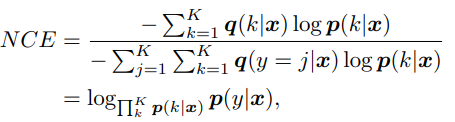

In [11]:
class NormalizedBinaryCrossentropy(Loss):
    def __init__(self, **kwargs):
        """
        Inicializa la clase NormalizedBinaryCrossentropy.

        Parámetros:
        -----------
        kwargs : dict
            Argumentos opcionales que se pasan a la clase base `Loss`.
        """
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        """
        Calcula la pérdida de entropía cruzada binaria normalizada.

        Parámetros:
        -----------
        y_true : Tensor
            Tensor de etiquetas verdaderas de forma `(N, 2)`, donde:
            - N: Número de muestras en el lote.
            - 2: Corresponde a las clases binarias (0 o 1).

        y_pred : Tensor
            Tensor de predicciones de forma `(N, 2)`, donde:
            - N: Número de muestras en el lote.
            - 2: Predicciones de probabilidad para las dos clases binarias.

        Retorna:
        --------
        Tensor
            Un tensor de pérdida de forma `(N,)`, que contiene la pérdida de entropía cruzada binaria normalizada para cada muestra.

        Descripción:
        ------------
        Esta clase implementa una versión normalizada de la pérdida de entropía cruzada binaria. La entropía cruzada binaria es una medida de la disimilitud entre dos distribuciones de probabilidad, a menudo utilizada como una función de pérdida en problemas de clasificación binaria.

        En esta implementación, la pérdida de entropía cruzada se normaliza utilizando las pérdidas teóricas asociadas a las etiquetas `[1, 0]` y `[0, 1]`, que representan las dos clases posibles. La normalización tiene como objetivo ajustar la pérdida para que sea más robusta frente a distribuciones de probabilidad sesgadas.

        Pasos:
        ------
        1. **Cálculo de la Entropía Cruzada Binaria**:
            - Se calcula la pérdida de entropía cruzada binaria estándar entre `y_true` y `y_pred`.

        2. **Cálculo de la Pérdida para Etiquetas Teóricas**:
            - Se generan las pérdidas teóricas `cce_left` y `cce_right` utilizando las etiquetas `[1.0, 0.0]` y `[0.0, 1.0]` respectivamente.

        3. **Normalización**:
            - La pérdida original se divide por la suma de las pérdidas teóricas, obteniendo así una versión normalizada de la pérdida.

        Ejemplo de Uso:
        ---------------
        ```python
        # Definir la pérdida en el modelo
        model.compile(optimizer='adam', loss=NormalizedBinaryCrossentropy())
        ```

        Notas:
        ------
        - Esta pérdida es útil en casos donde se desea mitigar el impacto de clases desbalanceadas, ya que la normalización ajusta la magnitud de la pérdida en función de las predicciones teóricas.
        - La normalización ayuda a hacer que el aprendizaje sea más estable y menos sensible a predicciones con alta confianza errónea.
        """
        
        # Obtener el tamaño del lote
        batch_size = tf.shape(y_pred)[0]  
        batch_size_float = tf.cast(batch_size, tf.float32)
        
        # Calcular la entropía cruzada binaria estándar
        cce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Crear etiquetas teóricas para cada clase
        left = tf.tile(tf.expand_dims([1.0, 0.0], axis=0), [batch_size, 1])
        right = tf.tile(tf.expand_dims([0.0, 1.0], axis=0), [batch_size, 1])
        
        # Calcular la entropía cruzada binaria para las etiquetas teóricas
        cce_left = tf.keras.losses.binary_crossentropy(left, y_pred)
        cce_right = tf.keras.losses.binary_crossentropy(right, y_pred)
        
        # Normalizar la entropía cruzada binaria estándar
        cce_norm = tf.divide(cce, (cce_left + cce_right))
        
        return cce_norm

# **Modelo GMRRNet**

Se debe tener en cuenta que el loss total usado es la combinación de los dos anteriores:

\begin{equation}\label{eq:GMRRloss}
\mathcal{L}(\mathbf{y},\hat{\mathbf{y}}|\mathcal{M}) = -\lambda\sum_{q=1}^Q y_q\log(\hat{y}_q(\mathcal{M})) + (1-\lambda) I_\alpha\left(\{\tilde{\mathbf{K}}_g(\mathcal{M})\}_{g=1}^{G}\right),
\end{equation}

In [12]:
def GMRRNet(nb_classes=2, Chans=64, Samples=320, 
                          kernLength=64, norm_rate=0.25, alpha=2): 
    """
    Construye un modelo de red neuronal convolucional basado en bloques de Inception con capas de convolución y cálculo de entropía de Renyi.

    Parámetros:
    -----------
    nb_classes : int, opcional (default=2)
        Número de clases de salida para la clasificación.
    
    Chans : int, opcional (default=64)
        Número de canales de entrada (dimensión espacial).
    
    Samples : int, opcional (default=320)
        Número de muestras de entrada (dimensión temporal).
    
    kernLength : int, opcional (default=64)
        Longitud del kernel para la primera capa convolucional.
    
    norm_rate : float, opcional (default=0.25)
        Tasa de normalización para la regularización en capas densas.
    
    alpha : int, opcional (default=2)
        Parámetro de orden para la entropía de Renyi, donde alpha=2 representa la entropía de Renyi cuadrática.

    Retorna:
    --------
    model : tf.keras.Model
        El modelo de red neuronal compilado listo para ser entrenado.
    
    Descripción:
    ------------
    Esta función crea y compila un modelo de red neuronal convolucional con las siguientes características:

    1. **Entrada**:
        - La entrada es un tensor de 4D de forma `(Chans, Samples, 1)`, donde `Chans` es el número de canales (dimensión espacial) y `Samples` es el número de muestras (dimensión temporal).

    2. **Primera Capa Convolucional**:
        - Una capa convolucional `Conv2D` con `F1=3` filtros y un kernel de longitud `kernLength=64`.

    3. **Bloque de Inception**:
        - Un bloque de Inception personalizado que aplica un filtro gaussiano con diferentes sigmas y pasa los resultados a una convolución `Conv2D`.
        - Se utilizan tres sigmas diferentes: `sigma1=0.8`, `sigma2=2.2`, y `sigma3=4.8`.
        - Se aplican tres convoluciones `Conv2D` con `F2=5` filtros cada una y se concatenan sus salidas.

    4. **Cálculo de la Entropía de Renyi**:
        - Las salidas de las capas de kernel gaussiano del bloque de Inception se concatenan y se calcula la entropía de Renyi marginal y conjunta usando la función `renyi_entropy` y `joint_renyi_entropy`, respectivamente.

    5. **Capas Finales**:
        - Se añade otra capa convolucional `Conv2D` con `F3=3` filtros seguida de una capa de normalización por lotes (`BatchNormalization`), aplanamiento (`Flatten`), y dos capas densas con una función de activación `softmax` para la salida final.

    6. **Compilación del Modelo**:
        - El modelo se compila con el optimizador `Adam`.
        - Se utiliza una combinación de dos funciones de pérdida:
            1. `NormalizedBinaryCrossentropy`: Una pérdida normalizada de entropía cruzada binaria.
            2. `RenyiMutualInformation`: Una pérdida basada en la información mutua de Renyi entre las entropías calculadas.
        - Las pérdidas se ponderan con `loss_weights=[0.8, 0.2]`.

    Ejemplo de Uso:
    ---------------
    ```python
    model = GMRRNet(nb_classes=2, Chans=64, Samples=320, kernLength=64, norm_rate=0.25, alpha=2)
    model.summary()
    ```
    
    Notas:
    ------
    - Este modelo es adecuado para tareas de clasificación binaria o multi-clase donde es importante capturar relaciones complejas entre características utilizando bloques de Inception.
    - La inclusión de la entropía de Renyi como una medida adicional puede mejorar la robustez del modelo en escenarios con incertidumbre.
    """
    
    ###### Definición de los filtros para las capas convolucionales
    F1 = 3
    F2 = 5
    F3 = 3
    
    ###### Definición de la entrada
    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    # Primera capa convolucional con normalización por lotes
    conv2D = Conv2D(F1, (1, kernLength), padding='same',
                    name='Conv2D_1',
                    input_shape=(Chans, Samples, 1),
                    use_bias=False)(input1)
    block1 = BatchNormalization()(conv2D)
    
    # Definición de los sigmas para el bloque de Inception
    sigma1 = 0.8
    sigma2 = 2.2
    sigma3 = 4.8

    # Bloque de Inception
    branch_k1, branch_k2, branch_k3, inception = inception_block(block1, [F2, F2, F2], [sigma1, sigma2, sigma3])
    
    ##############
    
    # Concatenación de las ramas del bloque de Inception para el cálculo de entropías
    concatenated_branches = concatenate([branch_k1, branch_k2, branch_k3], axis=-1)
    concatenated_branches = tf.transpose(concatenated_branches, perm=(0, 3, 1, 2))
    layer_entropy = Lambda(lambda x: renyi_entropy(x, alpha=alpha), name="entropy")(concatenated_branches)
    
    layer_joint_entropy = Lambda(lambda x: joint_renyi_entropy(x, alpha=alpha), name="joint_entropy")(concatenated_branches)
    
    concatenate_entropies = concatenate([layer_entropy, layer_joint_entropy], axis=-1, name="concatenated_entropies")
    
    ###############
    # Segunda capa convolucional con normalización por lotes y aplanamiento
    conv2D = Conv2D(F3, 3, padding='same',
                    name='Conv2D_2')(inception)
    
    conv2D = BatchNormalization()(conv2D)
    flatten = Flatten(name='flatten')(conv2D)
    
    # Capas densas con activación y normalización
    dense = Dense(64, kernel_constraint=max_norm(norm_rate), activation="relu")(flatten)
    dense = Dense(nb_classes, name='output', 
                  kernel_constraint=max_norm(norm_rate))(dense)
    softmax = Activation('softmax', name='out_activation')(dense)
    
    # Creación del modelo
    model = Model(inputs=input1, outputs=[softmax, concatenate_entropies])    
    
    # Compilación del modelo
    model.compile(optimizer='adam', 
                  loss=[NormalizedBinaryCrossentropy(), RenyiMutualInformation(C=tf.cast(64.0, tf.float64), name='MutualInfo')], 
                  loss_weights=[0.8, 0.2], 
                  metrics=[['binary_accuracy'], [None]])
    
    return model
